In [1]:
# C4T3

library('doParallel')

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [2]:
library('caret')

Loading required package: lattice

Loading required package: ggplot2



In [3]:
library('catboost')
library('corrplot')

corrplot 0.84 loaded



In [4]:
library('plotly')


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout




In [5]:
detectCores() # Result = Typically 4 to 6

[1] 12

In [6]:
# Setting a number of cores used for the cluster
cl <- makeCluster(10)

# Register Cluster
registerDoParallel(cl)

# Confirm how many cores are now "assigned" to R and RStudio
getDoParWorkers() # Result 2 

# Stop Cluster. After performing your tasks, stop your cluster. 
# stopCluster(cl)

[1] 10

<b>Exploring the Data</b>

In [7]:
samsung <- read.csv('galaxy_smallmatrix_labeled_9d.csv')

In [8]:
head(samsung)

iphone,samsunggalaxy,sonyxperia,nokialumina,htcphone,ios,googleandroid,iphonecampos,samsungcampos,sonycampos,...,sonyperunc,nokiaperunc,htcperunc,iosperpos,googleperpos,iosperneg,googleperneg,iosperunc,googleperunc,galaxysentiment
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,3
0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
samsung$galaxysentiment <- as.factor(samsung$galaxysentiment)

# str(iphone)

In [10]:
# summary(samsung)

In [11]:
sum(is.na(samsung))

[1] 0

In [12]:
# p <- plot_ly(iphone, x= ~iphone['iphonesentiment'], type='histogram')

# embed_notebook(p)

# hist(iphone$iphonesentiment,  breaks = 8, xlim = c(0,6), main = 'Sendiments distribution', col="chocolate")

'data.frame':	12911 obs. of  45 variables:
 $ samsunggalaxy  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 1 0 0 1 0 0 0 0 ...
 $ samsungcampos  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamunc      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonedispos   : int  0 1 0 0 0 0 2 0 0 0 ...
 $ htcdispos      : int  0

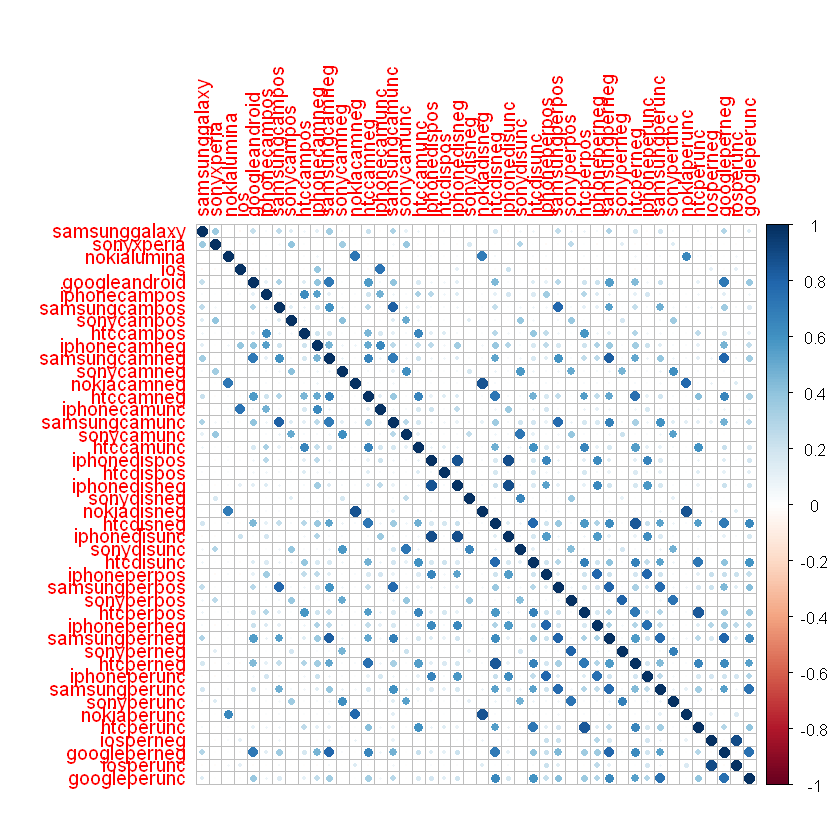

In [13]:
# Feature selection. Remove highly correlated (>0.9) independent variables

smsng_tmp <- samsung[, 1:(ncol(samsung)-1)]

tmp <- cor(samsung[, 1:(ncol(samsung)-1)])

tmp[upper.tri(tmp)] <- 0

diag(tmp) <- 0

samsung.f_corr <- smsng_tmp[,!apply(tmp,2,function(x) any(x >= 0.90))]

corrplot(cor(samsung.f_corr))


samsung.f_corr$galaxysentiment <- samsung$galaxysentiment
                                
str(samsung.f_corr)
                                
# number of variables shortened from 58 to 45

In [14]:
# Feature selection. Remove zero variance columns

samsung.f_zv <- samsung[ , apply(samsung, 2, var) != 0]


str(samsung.f_zv)
# number of variables kept the same

'data.frame':	12911 obs. of  59 variables:
 $ iphone         : int  1 1 1 0 1 2 1 1 4 1 ...
 $ samsunggalaxy  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 1 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 1 0 0 1 0 0 0 0 ...
 $ samsungcampos  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacampos    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  0


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.7101 0.3143    0.02253 0.06148         
         2   0.7127 0.3265    0.02045 0.05709         
         3   0.7201 0.3588    0.02269 0.06324         
         4   0.7322 0.3923    0.02661 0.07448         
         5   0.7372 0.4040    0.02825 0.07848         
         6   0.7371 0.4050    0.02872 0.07912         
         7   0.7370 0.4052    0.02910 0.07966         
         8   0.7367 0.4061    0.02872 0.07845         
         9   0.7446 0.4407    0.02986 0.07525         
        10   0.7468 0.4471    0.03158 0.07859         
        11   0.7465 0.4470    0.03155 0.07870         
        12   0.7458 0.4451    0.03127 0.07794         
        13   0.7461 0.4447    0.03240 0.07829         
        14   0.7465 0.4466    0.03092 0.07673         
        15   0.7481 0.4482    0.

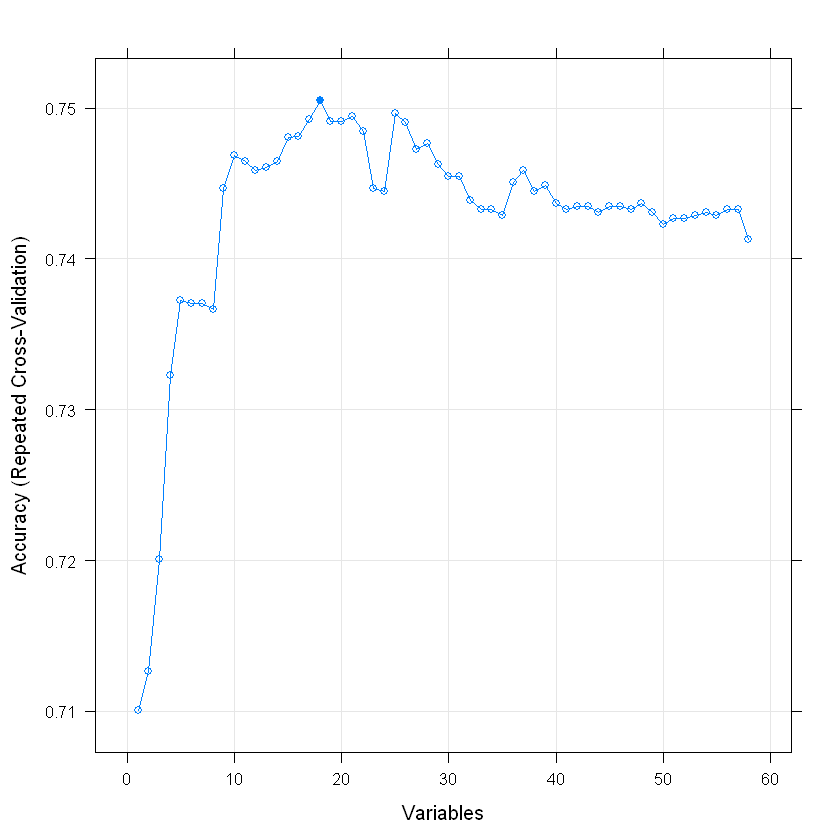

In [15]:
# Feature selection. Recursive Feature Elimination

set.seed(123)
samsungSample <- samsung[sample(1:nrow(samsung), 1000, replace=FALSE),]

# Set up rfeControl with randomforest, repeated cross validation and no updates
ctrl <- rfeControl(functions = rfFuncs, 
                   method = "repeatedcv",
                   repeats = 5,
                   verbose = FALSE)

# Use rfe and omit the response variable (attribute 59 iphonesentiment) 
rfeResults <- rfe(samsungSample[,1:(ncol(samsung)-1)], 
                  samsungSample$galaxysentiment, 
                  sizes=(1:(ncol(samsung)-1)), 
                  rfeControl=ctrl)

# Get results
rfeResults

# Plot results
plot(rfeResults, type=c("g", "o"))

In [16]:
# create new data set with rfe recommended features
samsungRFE <- samsung[,predictors(rfeResults)]

# add the dependent variable to iphoneRFE
samsungRFE$galaxysentiment <- samsung$galaxysentiment

# review outcome
str(samsungRFE)

'data.frame':	12911 obs. of  19 variables:
 $ iphone         : int  1 1 1 0 1 2 1 1 4 1 ...
 $ samsunggalaxy  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 1 0 0 0 0 0 0 ...
 $ iphonedisunc   : int  0 1 0 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonedispos   : int  0 1 0 0 0 0 2 0 0 0 ...
 $ iphoneperpos   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphoneperneg   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcdispos      : int  0 0 0 1 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 1 0 0 1 0 0 0 0 ...
 $ iphonedisneg   : int  0 1 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphoneperunc   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcperpos      : int  0 0 0 1 0 0 0 0 0 0 ...
 $ htcperneg      : int  0 0 0 1 0 0 0 0 0 0 ...
 $ galaxysentiment: Factor w/ 6 levels "0","1","2","3",..: 6 4 4 1 2 1 4 6 

<b>Modeling</b>

In [17]:
partition <- createDataPartition(samsung$galaxysentiment, p = .70, list = FALSE)
training <- samsung[partition,]
testing <- samsung[-partition,]

In [18]:
# Set 5 folds for cross-validation

fitControl0 <- trainControl(method = "repeatedcv", number = 5, repeats = 1)

In [19]:
# Train C5.0 model

C5Fit <- train(galaxysentiment~., data = training, method = "C5.0", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

C5Pred <- predict(C5Fit, testing)

postResample(C5Pred, testing$galaxysentiment)

Accuracy     Kappa 
0.7644020 0.5262028

In [20]:
# Train Random Forest model

rfFit <- train(galaxysentiment~., data = training, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rfPred <- predict(rfFit, testing)

postResample(rfPred, testing$galaxysentiment)

Accuracy     Kappa 
0.7677603 0.5321742

In [21]:
# Train Linear Support Vector Machines
library('e1071')


svmFit <- svm(galaxysentiment~., data = training, kernel =
"linear", metric = 'Kappa', scale = TRUE, trControl=fitControl0, tuneLength = 1)

svmPred <- predict(svmFit, testing)

postResample(svmPred, testing$galaxysentiment)

Accuracy     Kappa 
0.7008525 0.3613383

In [22]:
# Train k-NN
# install.packages('kknn')

kknnFit <- train(galaxysentiment~., data = training, method = "kknn", preProcess = c("center", "scale"), metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

kknnPred <- predict(kknnFit, testing)

postResample(kknnPred, testing$galaxysentiment)

Accuracy     Kappa 
0.6887109 0.4379590

In [23]:
# library('catboost')

# labels <- as.numeric(training$iphonesentiment)

# labels_test <- as.numeric(testing$iphonesentiment)

# cat_training <- training[, 1:(ncol(training)-1)]
# cat_training <- sapply(cat_training, as.numeric)

# cat_testing <- testing[, 1:(ncol(training)-1)]
# cat_testing <- sapply(cat_testing, as.numeric)


# fit_params <- list(iterations = 5000,
#                    loss_function = 'CrossEntropy',
#                   eval_metric = 'Kappa',
#                   task_type = 'CPU',
#                   random_seed = 123)

# train_pool <- catboost.load_pool(cat_training, label = labels)

# test_pool <- catboost.load_pool(cat_testing, label = labels_test)

# # catFit <- catboost.train(train_pool, params = fit_params)

# catFit <- catboost.train(train_pool, test_pool, params = fit_params)

# catPred <- catboost.predict(catFit, 
#                  test_pool)

# postResample(catPred, labels_test)

In [24]:
# catPred <- catboost.predict(catFit, 
#                  test_pool)

The best "out-of-the-box" model is Random Forest. Let's apply it to feature selected datasets

In [25]:
# Apply to a dataset where highly correlated variables are dropped

partition_fcorr <- createDataPartition(samsung.f_corr$galaxysentiment, p = .70, list = FALSE)

training_fcorr <- samsung.f_corr[partition_fcorr,]
testing_fcorr <- samsung.f_corr[-partition_fcorr,]

# Train Random Forest model

rfcFit <- train(galaxysentiment~., data = training_fcorr, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rfcPred <- predict(rfcFit, testing_fcorr)

postResample(rfcPred, testing_fcorr$galaxysentiment)

Accuracy     Kappa 
0.7357272 0.4670870

In [26]:
# Apply to a dataset where variables are those selected by Recursive Feature Elimination

partition_rfe <- createDataPartition(samsungRFE$galaxysentiment, p = .70, list = FALSE)

training_rfe <- samsungRFE[partition_rfe,]
testing_rfe <- samsungRFE[-partition_rfe,]

# Train Random Forest model

rfeFit <- train(galaxysentiment~., data = training_rfe, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rfePred <- predict(rfeFit, testing_rfe)

postResample(rfePred, testing_rfe$galaxysentiment)

Accuracy     Kappa 
0.7579437 0.5138447

In [49]:
###

modeldata <- resamples(list(C50 = C5Fit, kNN = kknnFit, RF_base = rfFit, RF_corr = rfcFit, RF_rfe = rfeFit))

summary(modeldata)


Call:
summary.resamples(object = modeldata)

Models: C50, kNN, RF_base, RF_corr, RF_rfe 
Number of resamples: 5 

Accuracy 
             Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
C50     0.7595357 0.7631433 0.7668882 0.7650443 0.7671460 0.7685083    0
kNN     0.6485888 0.6834532 0.6943062 0.6878235 0.6996681 0.7131012    0
RF_base 0.7540077 0.7631433 0.7708910 0.7684733 0.7732301 0.7810945    0
RF_corr 0.7169707 0.7206858 0.7308970 0.7283198 0.7341072 0.7389381    0
RF_rfe  0.7670172 0.7685493 0.7726770 0.7719000 0.7744610 0.7767956    0

Kappa 
             Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
C50     0.5237832 0.5248292 0.5338903 0.5311673 0.5345805 0.5387534    0
kNN     0.4113496 0.4246956 0.4490227 0.4401106 0.4505064 0.4649786    0
RF_base 0.5025604 0.5243541 0.5405975 0.5372662 0.5541497 0.5646694    0
RF_corr 0.4243233 0.4321933 0.4587166 0.4501257 0.4663494 0.4690459    0
RF_rfe  0.5343452 0.5356429 0.5458811 0.5454905 0.5487807 0.5628

In [28]:
###

kappaDiffs <- diff(modeldata, metric = "Kappa")
summary(kappaDiffs)


Call:
summary.diff.resamples(object = kappaDiffs)

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

Kappa 
        C50      kNN       RF_base   RF_corr   RF_rfe   
C50               0.091057 -0.006099  0.081042 -0.014323
kNN     0.013876           -0.097156 -0.010015 -0.105380
RF_base 1.000000 0.015574             0.087141 -0.008224
RF_corr 0.014960 0.925680  0.006713            -0.095365
RF_rfe  0.150745 0.018246  1.000000  0.019716           


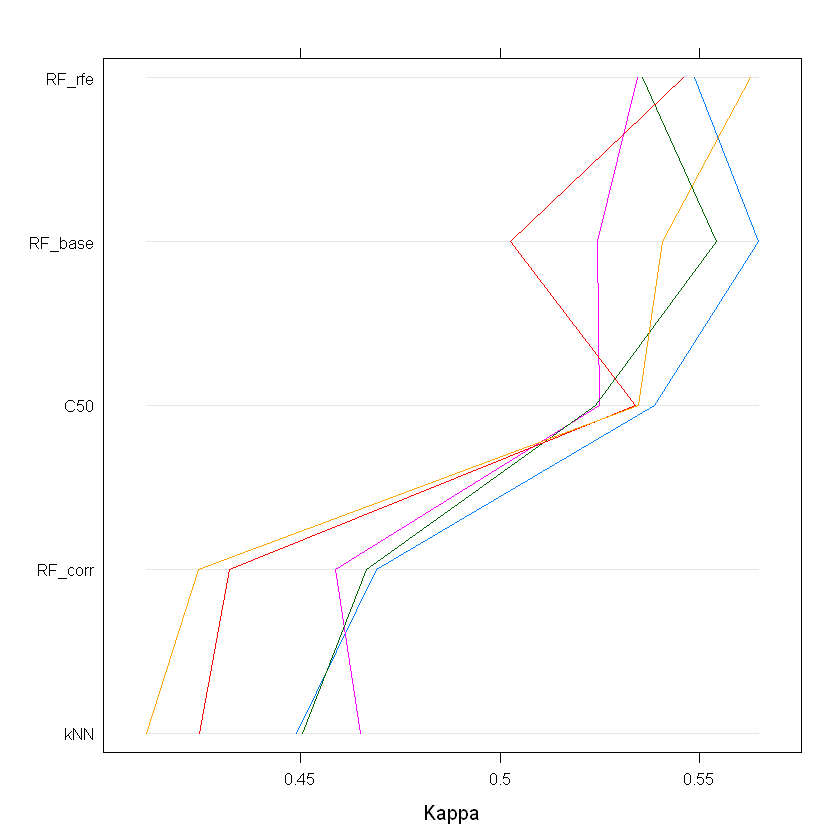

In [29]:
parallelplot(modeldata, metric = "Kappa")

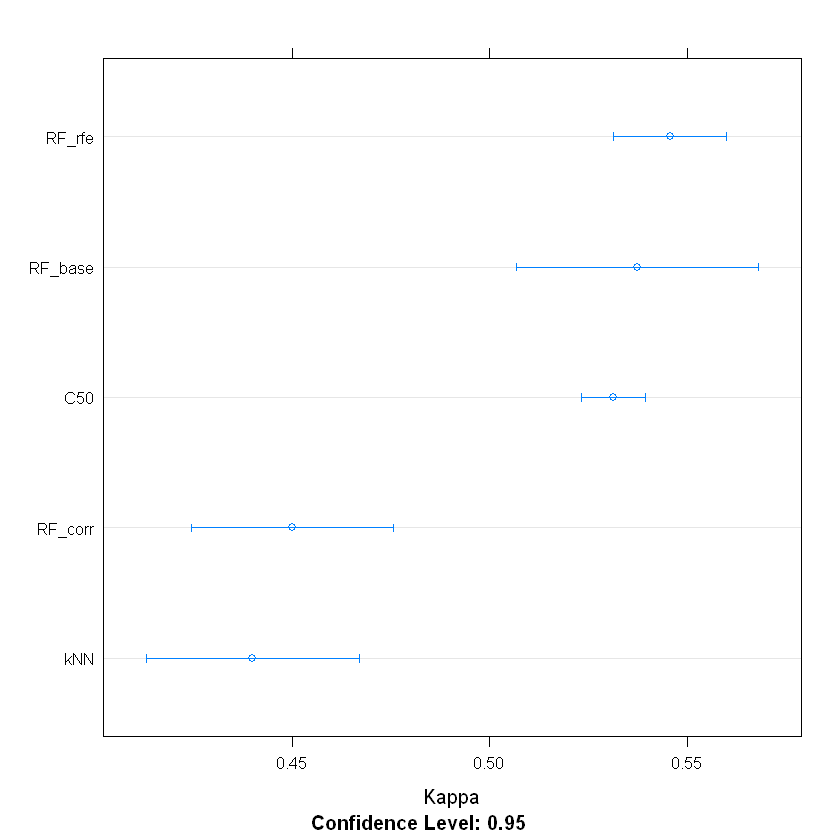

In [30]:
dotplot(modeldata, metric = "Kappa")

In [31]:
cmRF <- confusionMatrix(rfPred, testing$galaxysentiment) 
cmRF

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4    5
         0  350    0    0    2    6   23
         1    0    0    0    0    2    1
         2    1    0   15    1    1    2
         3    2    1    0  205    4   20
         4    4    2    0    2  128   17
         5  151  111  120  142  284 2274

Overall Statistics
                                         
               Accuracy : 0.7678         
                 95% CI : (0.7541, 0.781)
    No Information Rate : 0.6037         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.5322         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity           0.68898 0.000000 0.111111  0.58239  0.30118   0.9730
Specificity           0.99078 0.999201 0.998662  0.99233  0.99275   0.4733
Pos Pred Value

<b>Feature Engineering</b>

In [32]:
library('dplyr')

# create a new dataset that will be used for recoding sentiment
samsungRC <- samsung

# recode sentiment to combine factor levels 0 & 1 and 4 & 5
samsungRC$galaxysentiment <- recode(samsungRC$galaxysentiment, '0' = 1, '1' = 1, '2' = 2, '3' = 3, '4' = 4, '5' = 4) 

# samsungRC$iphonesentiment <- NULL
# inspect results
# summary(samsungRC)

# make iphonesentiment a factor
samsungRC$galaxysentiment <- as.factor(samsungRC$galaxysentiment)

str(samsungRC)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




'data.frame':	12911 obs. of  59 variables:
 $ iphone         : int  1 1 1 0 1 2 1 1 4 1 ...
 $ samsunggalaxy  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 1 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 1 0 0 1 0 0 0 0 ...
 $ samsungcampos  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacampos    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  0

In [33]:
# Apply Random Forest to recoded dataset

partition_rc <- createDataPartition(samsungRC$galaxysentiment, p = .70, list = FALSE)

training_rc <- samsungRC[partition_rc,]
testing_rc <- samsungRC[-partition_rc,]

# Train Random Forest model

rcFit <- train(galaxysentiment~., data = training_rc, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rcPred <- predict(rcFit, testing_rc)

postResample(rcPred, testing_rc$galaxysentiment)

Accuracy     Kappa 
0.8473657 0.6001779

In [34]:
cmRFrc <- confusionMatrix(rcPred, testing_rc$galaxysentiment) 
cmRFrc

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4
         1  356    3    2   29
         2    0   14    0    1
         3    7    1  200   21
         4  260  117  150 2711

Overall Statistics
                                          
               Accuracy : 0.8474          
                 95% CI : (0.8356, 0.8586)
    No Information Rate : 0.7133          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6002          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity           0.57143 0.103704  0.56818   0.9815
Specificity           0.98954 0.999732  0.99176   0.5252
Pos Pred Value        0.91282 0.933333  0.87336   0.8372
Neg Pred Value        0.92332 0.968628  0.95828   0.9196
Prevalence            0.16090 0.034866  0.09091   0.7133
Detection Rate      

Accuracy increased significantly, as well as a kappa score.

PCA

In [35]:
# data = training and testing from iphoneDF (no feature selection) 
# create object containing centered, scaled PCA components from training set
# excluded the dependent variable and set threshold to .95

preprocessParams <- preProcess(training[,-59], method=c("center", "scale", "pca"), thresh = 0.95)

print(preprocessParams)

Created from 9040 samples and 58 variables

Pre-processing:
  - centered (58)
  - ignored (0)
  - principal component signal extraction (58)
  - scaled (58)

PCA needed 25 components to capture 95 percent of the variance


In [36]:
# use predict to apply pca parameters, create training, exclude dependant
train.pca <- predict(preprocessParams, training[,-59])

# add the dependent to training
train.pca$galaxysentiment <- training$galaxysentiment

# use predict to apply pca parameters, create testing, exclude dependant
test.pca <- predict(preprocessParams, testing[,-59])

# add the dependent to training
test.pca$galaxysentiment <- testing$galaxysentiment

# inspect results
str(train.pca)
str(test.pca)

'data.frame':	9040 obs. of  26 variables:
 $ PC1            : num  0.6458 0.0502 -0.0407 0.6458 0.6119 ...
 $ PC2            : num  -0.1171 0.0926 0.1544 -0.1171 -0.0993 ...
 $ PC3            : num  0.3384 0.6731 -0.0662 0.3384 0.2736 ...
 $ PC4            : num  -0.521 -0.801 -0.367 -0.521 -0.451 ...
 $ PC5            : num  0.1618 -0.0962 1.6272 0.1618 0.1823 ...
 $ PC6            : num  -0.0452 0.0158 -0.3723 -0.0452 0.0746 ...
 $ PC7            : num  0.1216 0.1152 0.2501 0.1216 0.0638 ...
 $ PC8            : num  -0.00958 -0.23152 -0.45993 -0.00958 -0.06444 ...
 $ PC9            : num  -0.0343 0.0112 0.0111 -0.0343 -0.0366 ...
 $ PC10           : num  -0.0149 0.1574 -0.0193 -0.0149 -0.0236 ...
 $ PC11           : num  0.0379 -0.9481 0.8485 0.0379 -0.1654 ...
 $ PC12           : num  0.1895 -1.2552 0.0251 0.1895 0.2519 ...
 $ PC13           : num  -0.154 1.747 -0.126 -0.154 -0.192 ...
 $ PC14           : num  0.0913 -0.6759 -0.2221 0.0913 0.0565 ...
 $ PC15           : num  -0.0417

In [37]:
# Apply Random Forest to PCA transformed dataset

# Train Random Forest model

pcaFit <- train(galaxysentiment~., data = train.pca, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

pcaPred <- predict(pcaFit, test.pca)

postResample(pcaPred, test.pca$galaxysentiment)

Accuracy     Kappa 
0.7569104 0.5148649

In [38]:
cmRFpca <- confusionMatrix(pcaPred, test.pca$galaxysentiment) 
cmRFpca

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4    5
         0  350    1    0    5   15   36
         1    1    1    0    0    0    1
         2    2    0   15    2    2   10
         3    3    1    0  201    5   20
         4    3    2    0    0  121   28
         5  149  109  120  144  282 2242

Overall Statistics
                                          
               Accuracy : 0.7569          
                 95% CI : (0.7431, 0.7704)
    No Information Rate : 0.6037          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5149          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0  Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity           0.68898 0.0087719 0.111111  0.57102  0.28471   0.9593
Specificity           0.98305 0.9994677 0.995717  0.99176  0.99042   0.4759
Po

In [39]:
# Combine Recode + PCA

library('dplyr')

# create a new dataset that will be used for recoding sentiment
samsungRC_PCA <- samsung

# recode sentiment to combine factor levels 0 & 1 and 4 & 5
samsungRC_PCA$galaxysentiment <- recode(samsungRC_PCA$galaxysentiment, '0' = 1, '1' = 1, '2' = 2, '3' = 3, '4' = 4, '5' = 4) 

# inspect results
summary(samsungRC_PCA)
str(samsungRC_PCA)

# make iphonesentiment a factor
samsungRC_PCA$galaxysentiment <- as.factor(samsungRC_PCA$galaxysentiment)

     iphone       samsunggalaxy       sonyxperia       nokialumina      
 Min.   : 0.000   Min.   :0.00000   Min.   :0.00000   Min.   :0.000000  
 1st Qu.: 1.000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.000000  
 Median : 1.000   Median :0.00000   Median :0.00000   Median :0.000000  
 Mean   : 2.209   Mean   :0.07133   Mean   :0.02409   Mean   :0.002324  
 3rd Qu.: 1.000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.000000  
 Max.   :46.000   Max.   :8.00000   Max.   :8.00000   Max.   :2.000000  
    htcphone             ios         googleandroid      iphonecampos     
 Min.   :  0.0000   Min.   :0.0000   Min.   :0.00000   Min.   :  0.0000  
 1st Qu.:  0.0000   1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:  0.0000  
 Median :  0.0000   Median :0.0000   Median :0.00000   Median :  0.0000  
 Mean   :  0.1375   Mean   :0.1527   Mean   :0.03973   Mean   :  0.2891  
 3rd Qu.:  0.0000   3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:  0.0000  
 Max.   :479.0000   Max.   :6.0000   Max.   :

'data.frame':	12911 obs. of  59 variables:
 $ iphone         : int  1 1 1 0 1 2 1 1 4 1 ...
 $ samsunggalaxy  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ sonyxperia     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokialumina    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htcphone       : int  0 0 0 1 0 0 0 0 0 0 ...
 $ ios            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ googleandroid  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecampos   : int  0 0 1 0 0 1 0 0 0 0 ...
 $ samsungcampos  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ sonycampos     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacampos    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccampos      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamneg   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ samsungcamneg  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamneg     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nokiacamneg    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ htccamneg      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ iphonecamunc   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ samsungcamunc  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sonycamunc     : int  0

In [40]:
# use predict to apply pca parameters, create training, exclude dependant
trainRC.pca <- predict(preprocessParams, training_rc[,-59])

# add the dependent to training
trainRC.pca$galaxysentiment <- training_rc$galaxysentiment

# use predict to apply pca parameters, create testing, exclude dependant
testRC.pca <- predict(preprocessParams, testing_rc[,-59])

# add the dependent to training
testRC.pca$galaxysentiment <- testing_rc$galaxysentiment

# inspect results
str(trainRC.pca)
str(testRC.pca)

'data.frame':	9039 obs. of  26 variables:
 $ PC1            : num  0.6458 0.0502 -0.0407 0.6458 0.6119 ...
 $ PC2            : num  -0.1171 0.0926 0.1544 -0.1171 -0.0993 ...
 $ PC3            : num  0.3384 0.6731 -0.0662 0.3384 0.2736 ...
 $ PC4            : num  -0.521 -0.801 -0.367 -0.521 -0.451 ...
 $ PC5            : num  0.1618 -0.0962 1.6272 0.1618 0.1823 ...
 $ PC6            : num  -0.0452 0.0158 -0.3723 -0.0452 0.0746 ...
 $ PC7            : num  0.1216 0.1152 0.2501 0.1216 0.0638 ...
 $ PC8            : num  -0.00958 -0.23152 -0.45993 -0.00958 -0.06444 ...
 $ PC9            : num  -0.0343 0.0112 0.0111 -0.0343 -0.0366 ...
 $ PC10           : num  -0.0149 0.1574 -0.0193 -0.0149 -0.0236 ...
 $ PC11           : num  0.0379 -0.9481 0.8485 0.0379 -0.1654 ...
 $ PC12           : num  0.1895 -1.2552 0.0251 0.1895 0.2519 ...
 $ PC13           : num  -0.154 1.747 -0.126 -0.154 -0.192 ...
 $ PC14           : num  0.0913 -0.6759 -0.2221 0.0913 0.0565 ...
 $ PC15           : num  -0.0417

In [41]:
# Apply Random Forest to RC + PCA transformed dataset

# Train Random Forest model

rc_pcaFit <- train(galaxysentiment~., data = trainRC.pca, method = "rf", metric = 'Kappa', trControl=fitControl0, tuneLength = 1)

rc_pcaPred <- predict(rc_pcaFit, testRC.pca)

postResample(rc_pcaPred, testRC.pca$galaxysentiment)

Accuracy     Kappa 
0.8341942 0.5726170

Applying PCA do not improne neither Accuracy nor Kappa.

In [42]:
large_matrix = read.csv('LargeMatrix.csv')

In [43]:
large_matrix$galaxysentiment <- 0

In [44]:
# Predicting target values using recoded model:

Pred <- predict(rcFit, large_matrix)

In [45]:
large_matrix$galaxysentiment <- Pred

In [46]:
summary(Pred) 

1     2     3     4 
 9128   583  1350 10747

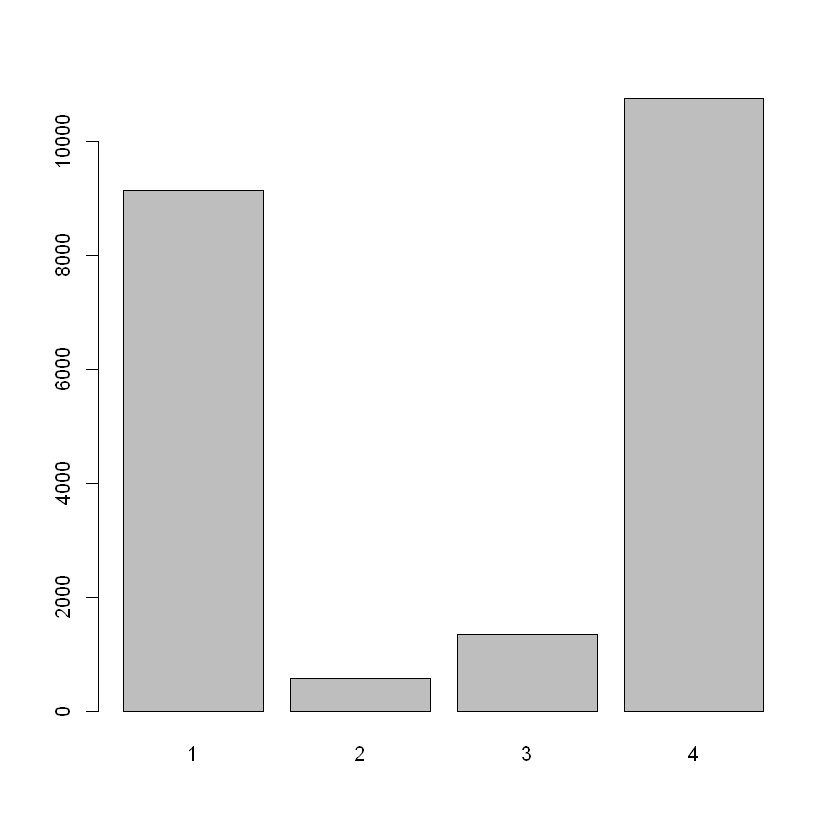

In [47]:
barplot(table(large_matrix$galaxysentiment))

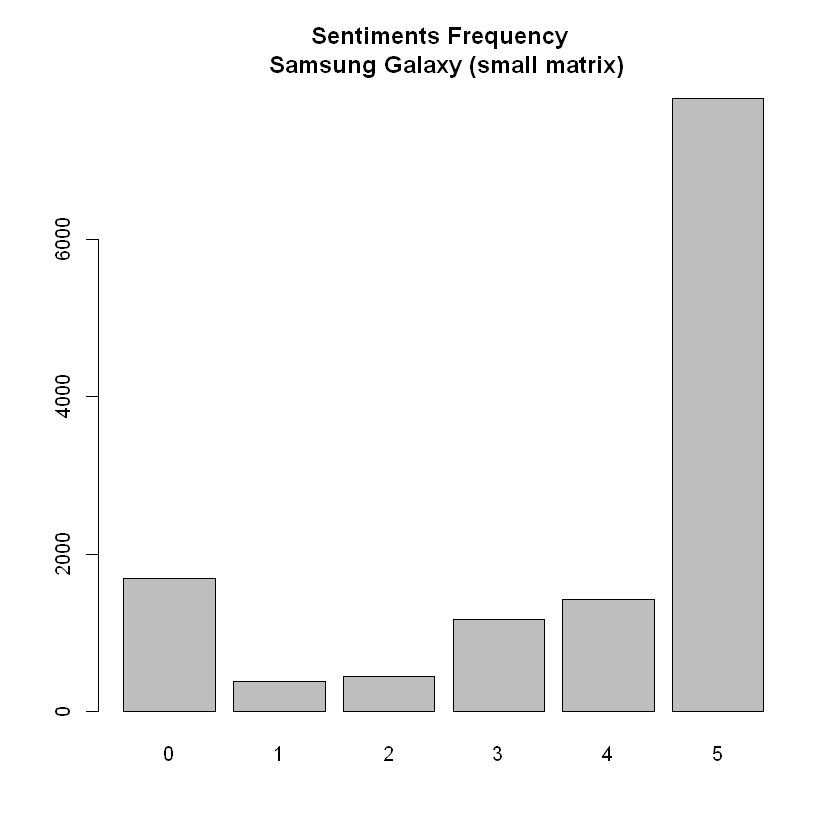

In [51]:
barplot(table(samsung$galaxysentiment), main = 'Sentiments Frequency \n Samsung Galaxy (small matrix)')